### **Setup**

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
df = pd.read_csv("../data/processed/imdb_clean.csv")
df = df[["clean_review", "sentiment"]]
df.head()

,clean_review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production the filming tech...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically theres a family where a little boy j...,negative
4,petter matteis love in the time of money is a ...,positive


### **Dataset Overview**

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   clean_review  50000 non-null  object
 1   sentiment     50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


<Axes: xlabel='sentiment'>

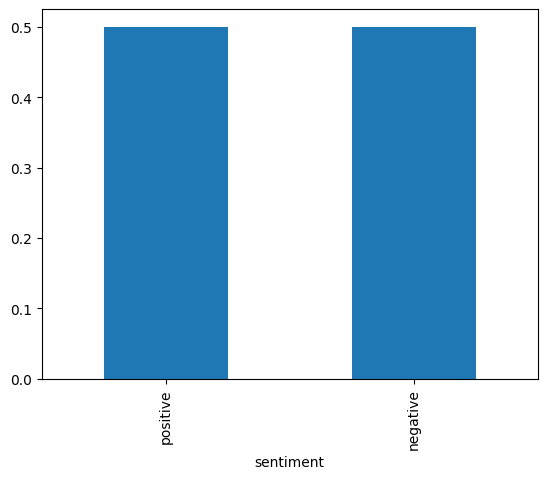

In [44]:
df["sentiment"].value_counts(normalize=True).plot(kind='bar')

The dataset seems to be distributed evenly between positive and negative reviews.

### **Analyzing Review Lengths**


<Axes: ylabel='Count'>

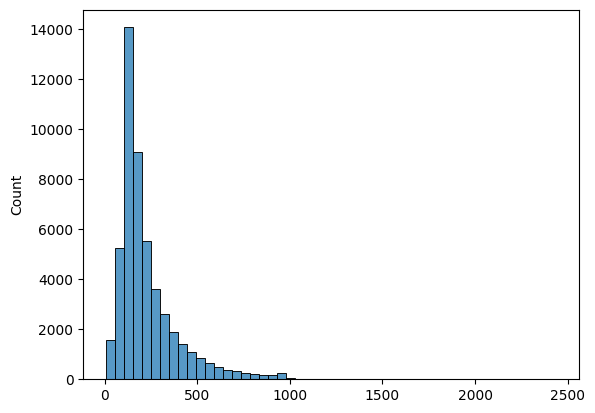

In [45]:
df['review_len'] = df['clean_review'].str.split().str.len()
sns.histplot(df['review_len'].values, bins=50)

### **Checking for Duplicates**

In [46]:
df.duplicated(subset='clean_review').sum()

420

In [47]:
df[df.duplicated(subset='clean_review')].value_counts('sentiment')

sentiment
negative    304
positive    116
Name: count, dtype: int64

There seems to be quite a bit of duplicate reviews but since they add up to less than
1% of the total dataset, I'm choosing to drop them entirely.

In [48]:
df = df.drop_duplicates(subset='clean_review', keep='first').reset_index(drop=True)


### **Word Frequency Analysis**

In [49]:
from collections import Counter
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

**Most Common Words Overall**

In [50]:
all_words = [
    w.lower()
    for review in df['clean_review']
    for w in review.split()
    if w.isalpha() and w.lower() not in stop
]

word_freq = Counter(all_words)
print(*word_freq.most_common(20), sep='\n')

('movie', 82909)
('film', 73989)
('one', 50008)
('like', 38516)
('good', 28300)
('even', 24083)
('would', 23802)
('time', 23107)
('really', 22731)
('see', 22232)
('story', 21919)
('much', 18732)
('well', 18320)
('get', 18038)
('great', 17600)
('bad', 17491)
('also', 17368)
('people', 17327)
('first', 16691)
('dont', 16493)


**Class-specific word frequencies**

In [51]:
pos_words = [
    w.lower()
    for review in df[df['sentiment'] == 'positive']['clean_review']
    for w in review.split()
    if w.isalpha() and w.lower() not in stop
]

neg_words = [
    w.lower()
    for review in df[df['sentiment'] == 'negative']['clean_review']
    for w in review.split()
    if w.isalpha() and w.lower() not in stop
]

In [52]:
pos_freq = Counter(pos_words)
neg_freq = Counter(neg_words)

print('Positive', *pos_freq.most_common(10), sep='\n', end='\n\n')
print('Negative', *neg_freq.most_common(10), sep='\n')

Positive
('film', 39303)
('movie', 35860)
('one', 25630)
('like', 17001)
('good', 14296)
('great', 12574)
('story', 12347)
('see', 11818)
('time', 11739)
('well', 10940)

Negative
('movie', 47049)
('film', 34686)
('one', 24378)
('like', 21515)
('even', 14762)
('good', 14004)
('bad', 13931)
('would', 13482)
('really', 12088)
('time', 11368)


### **N-gram Exploration**

In [53]:
from sklearn.feature_extraction.text import CountVectorizer

In [54]:
bigram_vectorizer = CountVectorizer(ngram_range=(2,2), stop_words='english', max_features=50)

X_bigrams = bigram_vectorizer.fit_transform(df['clean_review'])

In [55]:

bigram_counts = X_bigrams.toarray().sum(axis=0)
bigram_vocab = bigram_vectorizer.get_feature_names_out()

In [56]:
top_bigrams = sorted(zip(bigram_counts, bigram_vocab), reverse=True)[:20]
top_bigrams

[(3271, 'ive seen'),
 (2179, 'dont know'),
 (2124, 'special effects'),
 (1647, 'looks like'),
 (1466, 'movie just'),
 (1408, 'waste time'),
 (1359, 'im sure'),
 (1351, 'good movie'),
 (1282, 'watch movie'),
 (1282, 'dont think'),
 (1277, 'look like'),
 (1237, 'new york'),
 (1217, 'low budget'),
 (1185, 'years ago'),
 (1062, 'pretty good'),
 (1058, 'year old'),
 (1053, 'high school'),
 (1028, 'main character'),
 (1027, 'movie like'),
 (973, 'watching movie')]

**Compare by Sentiment**

In [57]:
def top_ngrams(corpus, n=2, top_k=15):
    vec = CountVectorizer(ngram_range=(n, n), stop_words='english').fit(corpus)
    bag = vec.transform(corpus)
    sum_words = bag.sum(axis=0)
    words_freq = [(w, sum_words[0, idx]) for w, idx in vec.vocabulary_.items()]
    return sorted(words_freq, key=lambda x: x[1], reverse=True)[:top_k]

Bigrams

In [58]:
print('Positive: ', top_ngrams(df[df['sentiment'] == 'positive']['clean_review']))

Positive:  [('ive seen', 1475), ('dont know', 900), ('new york', 801), ('special effects', 761), ('years ago', 702), ('great movie', 671), ('good movie', 655), ('real life', 569), ('dont think', 568), ('saw movie', 565), ('pretty good', 563), ('im sure', 558), ('watch movie', 547), ('great film', 543), ('years later', 528)]


In [59]:
print('Negative: ', top_ngrams(df[df['sentiment'] == 'negative']['clean_review']))

Negative:  [('ive seen', 1796), ('special effects', 1363), ('waste time', 1342), ('dont know', 1279), ('looks like', 1233), ('movie just', 1028), ('look like', 935), ('low budget', 834), ('bad movie', 834), ('im sure', 801), ('watch movie', 735), ('worst movie', 726), ('dont think', 714), ('good movie', 696), ('really bad', 672)]


Trigrams

In [60]:
print('Positive: ', top_ngrams(df[df['sentiment'] == 'positive']['clean_review'], 3))

Positive:  [('new york city', 180), ('world war ii', 152), ('did great job', 150), ('does good job', 139), ('does great job', 134), ('based true story', 126), ('films ive seen', 124), ('did good job', 115), ('movies ive seen', 108), ('movie ive seen', 108), ('film ive seen', 94), ('seen long time', 86), ('highly recommend movie', 85), ('international film festival', 79), ('ive seen movie', 70)]


In [61]:
print('Negative: ', top_ngrams(df[df['sentiment'] == 'negative']['clean_review'], 3))

Negative:  [('dont waste time', 321), ('movie ive seen', 239), ('worst movie seen', 188), ('waste time money', 170), ('movies ive seen', 162), ('worst movie ive', 138), ('doesnt make sense', 125), ('bad acting bad', 121), ('worst movies seen', 117), ('complete waste time', 113), ('film ive seen', 111), ('worst ive seen', 98), ('worst movies ive', 96), ('films ive seen', 92), ('mystery science theater', 92)]


**Most Common Words Per Class**

In [62]:
pos_words = [w.lower() for review in df[df['sentiment']=="positive"]['clean_review'] for w in review.split()]
neg_words = [w.lower() for review in df[df['sentiment']=="negative"]['clean_review'] for w in review.split()]

pos_counts = Counter(pos_words)
neg_counts = Counter(neg_words)

# words that appear way more in either class
unique_pos = [(w, c) for w, c in pos_counts.items() if c > 50 and c > 2*neg_counts[w]]
unique_neg = [(w, c) for w, c in neg_counts.items() if c > 50 and c > 2*pos_counts[w]]

print("Positive-leaning words:", *sorted(unique_pos, key=lambda x: -x[1])[:20], sep='\n', end='\n\n')
print("Negative-leaning words:", *sorted(unique_neg, key=lambda x: -x[1])[:20], sep='\n')

Positive-leaning words:
('great', 12574)
('love', 8367)
('best', 8272)
('excellent', 3242)
('beautiful', 2939)
('war', 2736)
('wonderful', 2597)
('perfect', 2334)
('performances', 2286)
('loved', 2187)
('amazing', 1930)
('favorite', 1800)
('brilliant', 1760)
('enjoyed', 1699)
('highly', 1595)
('heart', 1506)
('strong', 1453)
('today', 1378)
('simple', 1337)
('hilarious', 1331)

Negative-leaning words:
('bad', 13931)
('nothing', 5669)
('worst', 4740)
('minutes', 4123)
('script', 3859)
('money', 2970)
('poor', 2890)
('awful', 2872)
('boring', 2822)
('stupid', 2755)
('instead', 2746)
('terrible', 2745)
('waste', 2554)
('worse', 2315)
('supposed', 2223)
('horrible', 2094)
('couldnt', 2078)
('oh', 1871)
('guess', 1749)
('low', 1709)


## **Save Data**

In [63]:
df.to_csv("../data/processed/imdb_clean.csv")